In [5]:
library("leaps")
library("lmtest")
library("nlme")
library("ape")
library("broom")
library("FRK")
library("purrr")
library("lattice")
library("ggplot2")
library("RColorBrewer")
library("dplyr")
library("gstat")
library("sp")
library("spacetime")
library("STRbook")
library("tidyr")


Attaching package: 'STRbook'


The following objects are masked from 'package:FRK':

    LinePlotTheme, NOAA_df_1990




In [6]:
data("NOAA_df_1990", package = "STRbook")
Tmax <- filter(NOAA_df_1990,
# subset the data
proc == "Tmax" &
# only max temperature
month == 7 &
# July
year == 1993)

In [7]:
G <- auto_basis(data = Tmax[,c("lon","lat")] %>%
# Take Tmax
SpatialPoints(),
# To sp obj
nres = 1,
# One resolution
type = "Gaussian")

In [8]:
S <- eval_basis(basis = G,
# basis functions
s = Tmax[,c("lon","lat")] %>%
# spat locations
as.matrix()) %>%
# conv. to matrix
as.matrix()
# results as matrix
colnames(S) <- paste0("B", 1:ncol(S))

In [9]:
Tmax2 <- cbind(Tmax, S) %>%
# append S to Tmax
select(-year, -month, -proc,
# and remove vars we
-julian, -date)

In [10]:
Tmax_no_14 <- filter(Tmax2, !(day == 14))
# remove day 14

In [11]:
Tmax_July_lm <- lm(z ~ (lon + lat + day)^2 + .,
# model
data = select(Tmax_no_14, -id))
# omit id

In [12]:
Tmax_July_lm %>% summary()


Call:
lm(formula = z ~ (lon + lat + day)^2 + ., data = select(Tmax_no_14, 
    -id))

Residuals:
     Min       1Q   Median       3Q      Max 
-17.5136  -2.4797   0.1098   2.6644  14.1659 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 192.243242  97.854126   1.965 0.049531 *  
lon           1.756918   1.088175   1.615 0.106486    
lat          -1.317402   2.555626  -0.515 0.606239    
day          -1.216456   0.133547  -9.109  < 2e-16 ***
B1           16.646617   4.832399   3.445 0.000577 ***
B2           18.528159   3.056082   6.063 1.46e-09 ***
B3           -6.606896   3.171759  -2.083 0.037312 *  
B4           30.545361   4.369591   6.990 3.20e-12 ***
B5           14.739147   2.746866   5.366 8.52e-08 ***
B6          -17.541177   3.423081  -5.124 3.13e-07 ***
B7           28.472198   3.551900   8.016 1.42e-15 ***
B8          -27.348145   3.164317  -8.643  < 2e-16 ***
B9          -10.234777   4.456735  -2.296 0.021701 *  
B10          10.558234   

In [13]:
Tmax_July_gls <- gls(z ~ (lon + lat + day)^2 + .,
data = select(Tmax_no_14, -id),
correlation = corGaus(value = 0.5,
form = ~ lon + lat + day,
fixed = TRUE))

In [15]:
library(dplyr)

Tmax_July_lm4 <- list()  # Initialize the list

for(i in 0:4) {
  # For four steps (after intercept model)
  ## Carry out stepwise forward selection for i steps
  Tmax_July_lm4[[i + 1]] <- step(
    lm(z ~ 1, data = select(Tmax_no_14, -id)),  # Intercept-only model
    scope = z ~ (lon + lat + day)^2 + .,  # Scope for the model
    direction = 'forward',  # Direction for stepwise selection
    steps = i  # Number of steps
  )
}


Start:  AIC=16312.78
z ~ 1

Start:  AIC=16312.78
z ~ 1

       Df Sum of Sq    RSS   AIC
+ lat   1    149619  88431 12365
+ day   1      1551 236499 16289
+ lon   1       465 237585 16307
<none>              238050 16313

Step:  AIC=12364.63
z ~ lat

Start:  AIC=16312.78
z ~ 1

       Df Sum of Sq    RSS   AIC
+ lat   1    149619  88431 12365
+ day   1      1551 236499 16289
+ lon   1       465 237585 16307
<none>              238050 16313

Step:  AIC=12364.63
z ~ lat

       Df Sum of Sq   RSS   AIC
+ day   1   1550.49 86880 12296
+ lon   1     44.77 88386 12365
<none>              88431 12365

Step:  AIC=12296.07
z ~ lat + day

Start:  AIC=16312.78
z ~ 1

       Df Sum of Sq    RSS   AIC
+ lat   1    149619  88431 12365
+ day   1      1551 236499 16289
+ lon   1       465 237585 16307
<none>              238050 16313

Step:  AIC=12364.63
z ~ lat

       Df Sum of Sq   RSS   AIC
+ day   1   1550.49 86880 12296
+ lon   1     44.77 88386 12365
<none>              88431 12365

Step:  AIC

In [16]:
regfit.full = regsubsets(z ~ 1 + (lon + lat + day)^2 + .,
# model
data = select(Tmax_no_14, -id),
method = "forward",
nvmax = 4)

In [17]:
regfit.summary <- summary(regfit.full)

In [18]:
set.seed(1) # Fix seed for reproducibility
Tmax_no_14_2 <- Tmax_no_14 %>%
mutate(B13 = B5 + 0.01*rnorm(nrow(Tmax_no_14)))

In [19]:
Tmax_July_lm3 <- lm(z ~ (lon + lat + day)^2 + .,
data = Tmax_no_14_2 %>%
select(-id))

In [20]:
summary(Tmax_July_lm3)


Call:
lm(formula = z ~ (lon + lat + day)^2 + ., data = Tmax_no_14_2 %>% 
    select(-id))

Residuals:
     Min       1Q   Median       3Q      Max 
-17.7869  -2.4946   0.1034   2.6743  14.3179 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 195.365087  97.819550   1.997 0.045872 *  
lon           1.785474   1.087752   1.641 0.100786    
lat          -1.414127   2.554836  -0.554 0.579946    
day          -1.215853   0.133485  -9.109  < 2e-16 ***
B1           16.675811   4.830184   3.452 0.000561 ***
B2           18.379495   3.055443   6.015 1.96e-09 ***
B3           -6.470935   3.170917  -2.041 0.041345 *  
B4           30.303993   4.368998   6.936 4.68e-12 ***
B5            0.603294   7.092149   0.085 0.932214    
B6          -17.322017   3.423000  -5.060 4.37e-07 ***
B7           28.135550   3.553672   7.917 3.12e-15 ***
B8          -27.002158   3.166901  -8.526  < 2e-16 ***
B9          -10.181760   4.454742  -2.286 0.022330 *  
B10          10.3796

In [21]:
vcov(Tmax_July_lm3)[c("B5", "B13"),c("B5", "B13")] %>%
cov2cor()

,B5,B13
B5,1.0000000,-0.9220244
B13,-0.9220244,1.0000000


In [22]:
Tmax_no_14$residuals <- residuals(Tmax_July_lm)

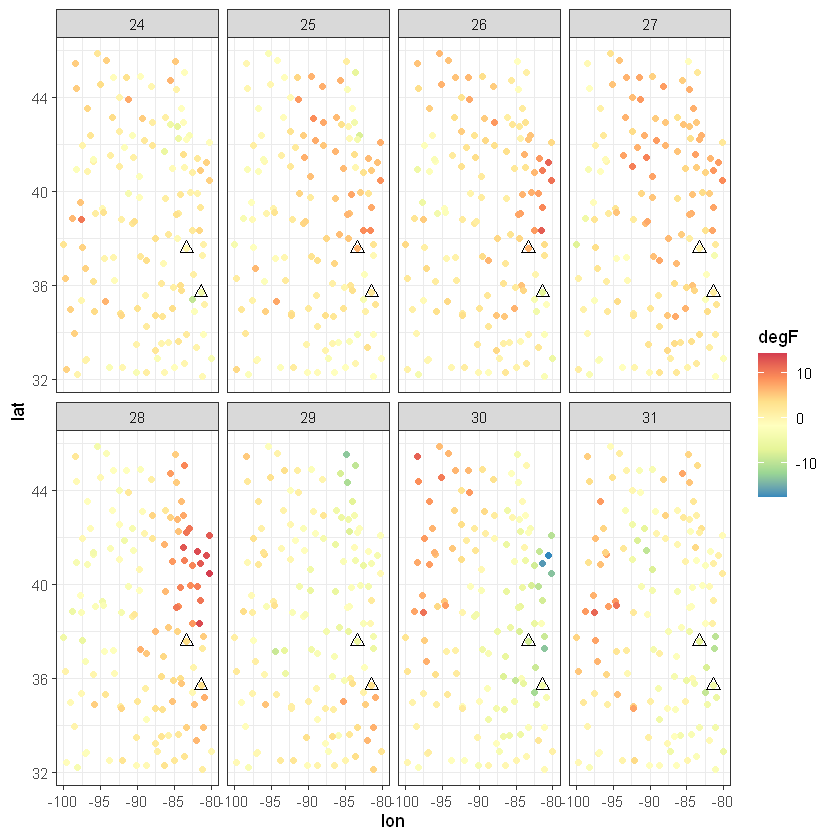

In [24]:
g <- ggplot(filter(Tmax_no_14, day %in% 24:31)) +
geom_point(aes(lon, lat, colour = residuals)) +
facet_wrap(~ day, ncol=4) +
col_scale(name = "degF") +
geom_point(data = filter(Tmax_no_14,day %in% 24:31 &
id %in% c(3810, 3889)),
aes(lon, lat),
colour = "black",
pch = 2, size = 2.5) +
theme_bw()

g

In [25]:
P <- list()
# init list
days <- c(1:13, 15:31)
# set of days
for(i in seq_along(days)) {
# for each day
Tmax_day <- filter(Tmax_no_14,
day == days[i])
# filter by day
station.dists <- Tmax_day %>%
# take the data
select(lon, lat) %>%
# extract coords.
dist() %>%
# comp. dists.
as.matrix()
# conv. to matrix
station.dists.inv <- 1/station.dists
# weight matrix
diag(station.dists.inv) <- 0
# 0 on diag
P[[i]] <- Moran.I(Tmax_day$residuals,
# run Moran's I
station.dists.inv) %>%
do.call("cbind", .)
# conv. to df
}

In [26]:
do.call("rbind", P) %>% head()

observed,expected,sd,p.value
0.2716679,-0.007575758,0.01235583,0
0.2264147,-0.007575758,0.01236886,0
0.2113966,-0.007575758,0.01236374,0
0.1626477,-0.007575758,0.01238872,0
0.2580333,-0.007575758,0.01241006,0
0.1216741,-0.007575758,0.01227211,0


In [27]:
station.dists <- Tmax_no_14 %>%
# take the data
select(lon, lat, day) %>%
# extract coordinates
dist() %>%
# compute distances
as.matrix()

In [28]:
station.dists.inv <- 1/station.dists
diag(station.dists.inv) <- 0
Moran.I(Tmax_no_14$residuals, station.dists.inv)$p.value

[1] 0

In [29]:
TS1 <- filter(Tmax_no_14, id == 3810)$residuals
TS2 <- filter(Tmax_no_14, id == 3889)$residuals

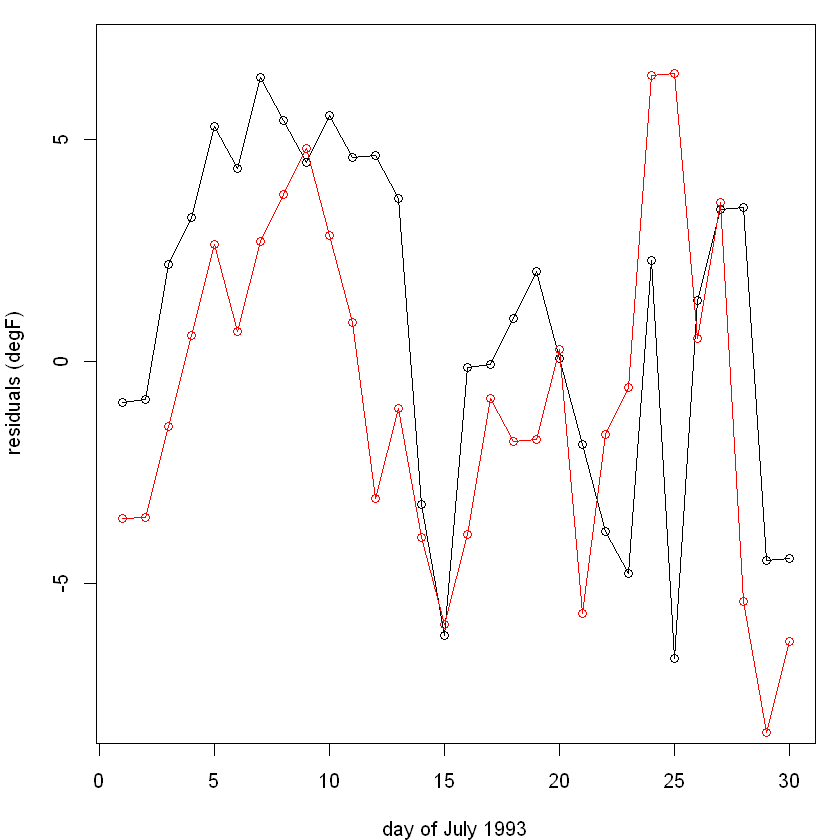

In [30]:
par(mar=c(4, 4, 1, 1))
plot(TS1,
# Station 3810 residuals
xlab = "day of July 1993",
ylab = "residuals (degF)",
type = 'o', ylim = c(-8, 7))
lines(TS2,
# Station 3889 residuals
xlab = "day of July 1993",
ylab = "residuals (degF)",
type = 'o', col = "red")

In [31]:
nested_Tmax_no_14 <- group_by(Tmax_no_14, lon, lat) %>% nest()
head(nested_Tmax_no_14, 3)

lat      lon       data <NA> <NA> <NA>        <NA>       <NA>      <NA>     
1  39.35000 -81.43333  1   3804 82   0.002876094 0.05719898 0.3081284 0.4496073
2  35.73333 -81.38333  2   3804 84   0.002876094 0.05719898 0.3081284 0.4496073
3  35.60000 -88.91666  3   3804 88   0.002876094 0.05719898 0.3081284 0.4496073
4  39.35000 -81.43333  4   3804 90   0.002876094 0.05719898 0.3081284 0.4496073
5  35.73333 -81.38333  5   3804 92   0.002876094 0.05719898 0.3081284 0.4496073
6  35.60000 -88.91666  6   3804 91   0.002876094 0.05719898 0.3081284 0.4496073
7  39.35000 -81.43333  7   3804 92   0.002876094 0.05719898 0.3081284 0.4496073
8  35.73333 -81.38333  8   3804 94   0.002876094 0.05719898 0.3081284 0.4496073
9  35.60000 -88.91666  9   3804 96   0.002876094 0.05719898 0.3081284 0.4496073
10 39.35000 -81.43333 10   3804 93   0.002876094 0.05719898 0.3081284 0.4496073
11 35.73333 -81.38333 11   3804 94   0.002876094 0.05719898 0.3081284 0.4496073
12 35.60000 -88.91666 12   3804 85   0.002876094 0.05719898 0.3081284 0.4496073
13 39.35000 -81.43333 13   3804 92   0.002876094 0.05719898 0.3081284 0.4496073
14 35.73333 -81.38333 15   3804 80   0.002876094 0.05719898 0.3081284 0.4496073
15 35.60000 -88.91666 16   3804 85   0.002876094 0.05719898 0.3081284 0.4496073
16 39.35000 -81.43333 17   3804 87   0.002876094 0.05719898 0.3081284 0.4496073
17 35.73333 -81.38333 18   3804 90   0.002876094 0.05719898 0.3081284 0.4496073
18 35.60000 -88.91666 19   3804 87   0.002876094 0.05719898 0.3081284 0.4496073
19 39.35000 -81.43333 20   3804 86   0.002876094 0.05719898 0.3081284 0.4496073
20 35.73333 -81.38333 21   3804 82   0.002876094 0.05719898 0.3081284 0.4496073
21 35.60000 -88.91666 22   3804 81   0.002876094 0.05719898 0.3081284 0.4496073
22 39.35000 -81.43333 23   3804 82   0.002876094 0.05719898 0.3081284 0.4496073
23 35.73333 -81.38333 24   3804 87   0.002876094 0.05719898 0.3081284 0.4496073
24 35.60000 -88.91666 25   3804 92   0.002876094 0.05719898 0.3081284 0.4496073
25 39.35000 -81.43333 26   3804 94   0.002876094 0.05719898 0.3081284 0.4496073
26 35.73333 -81.38333 27   3804 92   0.002876094 0.05719898 0.3081284 0.4496073
27 35.60000 -88.91666 28   3804 95   0.002876094 0.05719898 0.3081284 0.4496073
28 39.35000 -81.43333 29   3804 86   0.002876094 0.05719898 0.3081284 0.4496073
29 35.73333 -81.38333 30   3804 76   0.002876094 0.05719898 0.3081284 0.4496073
30 35.60000 -88.91666 31   3804 85   0.002876094 0.05719898 0.3081284 0.4496073
   <NA>        <NA>      <NA>      <NA>      <NA>        <NA>       <NA>     
1  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
2  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
3  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
4  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
5  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
6  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
7  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
8  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
9  0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
10 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
11 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
12 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
13 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
14 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
15 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
16 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
17 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
18 0.006202851 0.1233606 0.6645381 0.9696646 0.003315591 0.06593958 0.3552136
19 0.006202851 0.1233606 0.6645381 0.9696

In [32]:
dwtest_one_station <- function(data)
dwtest(residuals ~ 1, data = data)

In [33]:
dwtest_one_station(nested_Tmax_no_14$data[[1]])


	Durbin-Watson test

data:  residuals ~ 1
DW = 0.98224, p-value = 0.001222
alternative hypothesis: true autocorrelation is greater than 0


In [34]:
map(nested_Tmax_no_14$data, dwtest_one_station) %>% head()

[[1]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 0.98224, p-value = 0.001222
alternative hypothesis: true autocorrelation is greater than 0


[[2]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 0.92119, p-value = 0.0005855
alternative hypothesis: true autocorrelation is greater than 0


[[3]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 1.5945, p-value = 0.1285
alternative hypothesis: true autocorrelation is greater than 0


[[4]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 1.1583, p-value = 0.007274
alternative hypothesis: true autocorrelation is greater than 0


[[5]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 0.8274, p-value = 0.0001634
alternative hypothesis: true autocorrelation is greater than 0


[[6]]

	Durbin-Watson test

data:  residuals ~ 1
DW = 1.212, p-value = 0.01152
alternative hypothesis: true autocorrelation is greater than 0



In [35]:
dwtest_one_station_tidy <- nested_Tmax_no_14$data[[1]] %>%
dwtest_one_station() %>%
tidy()

In [36]:
dwtest_one_station_tidy[, 1:3]

statistic,p.value,method
<dbl>,<dbl>,<chr>
0.9822373,0.001222279,Durbin-Watson test


In [37]:
Tmax_DW_no_14 <- nested_Tmax_no_14 %>%
mutate(dwtest = map(data, dwtest_one_station)) %>%
mutate(test_df = map(dwtest, tidy)) %>%
unnest(test_df)

In [43]:
# Tmax_DW_no_14 %>% select(-method, -alternative) %>% head(3)

mean(Tmax_DW_no_14$p.value < 0.05/nrow(Tmax_DW_no_14)) * 100

[1] 21.80451

In [44]:
# str(Tmax_DW_no_14)
data("STObj3", package = "STRbook")
STObj4 <- STObj3[, "1993-07-01::1993-07-31"]


In [45]:
STObj4@data <- left_join(STObj4@data, Tmax_no_14)


Joining with `by = join_by(day, id, z)`


In [46]:
vv <- variogram(object = residuals ~ 1, # fixed effect component
data = STObj4,
# July data
width = 80,
# spatial bin (80 km)
cutoff = 1000,
# consider pts < 1000 km apart
tlags = 0.01:6.01)

Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j)

In [47]:
pred_grid <- expand.grid(lon = seq(-100, -80, length = 20),
lat = seq(32, 46, length = 20),
day = seq(4, 29, length = 6))

In [48]:
Spred <- eval_basis(basis = G,
# basis functs
s = pred_grid[,c("lon","lat")] %>%
# pred locs
as.matrix()) %>%
# conv. to matrix
as.matrix()
# results as matrix
colnames(Spred) <- paste0("B", 1:ncol(Spred)) # assign col names
pred_grid <- cbind(pred_grid, Spred)

In [49]:
linreg_pred <- predict(Tmax_July_lm,
newdata = pred_grid,
interval = "prediction")

In [50]:
pred_grid$z_pred <- linreg_pred[,1]
pred_grid$z_err <- (linreg_pred[,3] - linreg_pred[,2]) / (2*1.96)